# SmartBeds - Preprocesado de Datos

## Grado en Ingeniería Informática
## Universidad de Burgos
##### José Luis Garrido Labrador

In [2]:
import pandas as pd # se importa pandas como pd
import numpy as np  #numpy como np
import matplotlib.pyplot as plt

### Lectura

In [3]:
import loadData as ld

datos = ld.load(r"../data/")

datos = ld.preprocess(datos)

/home/jlgarridol/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3185: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  if (yield from self.run_code(code, result)):


### Datos manuales

In [4]:
datos = ld.newSeizure(datos,'2018-11-10 3:30:00',60*20)

### Preprocesado

In [5]:
# Ordención
datos = datos.sort_values(by='DateTime')

In [6]:
# Eliminación de negativos y filtrado
for d in datos:
    if datos[d].dtype == np.float64:
        datos.loc[datos[d]<5.0,d]=0.0

In [7]:
# Normalización
tubesNorm = ld.normalize(datos.iloc[:,1:13])
datos=pd.concat([datos['DateTime'],tubesNorm*100,datos['target']],axis=1)
datos.head()

,DateTime,P1,P2,P3,P4,P5,P6,P7,P8,P9,P10,P11,P12,target
4041041,2018-10-30 21:20:23,0.0,27.835052,30.208333,22.772277,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False
4041042,2018-10-30 21:20:23,0.0,26.804124,29.166667,21.782178,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False
4041043,2018-10-30 21:20:23,0.0,25.773196,28.125000,21.782178,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False
4041044,2018-10-30 21:20:24,0.0,26.804124,29.166667,22.772277,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False
4041045,2018-10-30 21:20:25,0.0,26.804124,30.208333,22.772277,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False


In [8]:
# Suavizado
from scipy import signal

dt = datos.iloc[:,1:13]
dtN = dt.copy()
b, a = signal.butter(3, 0.05)
for i in range(len(dt.columns)):
    xn = dt.iloc[:,i]
    y = signal.filtfilt(b, a, xn)
    dtN["P"+str(i+1)]=y

/usr/local/anaconda3/envs/TFG/lib/python3.6/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


In [9]:
## Eliminación de tubos con poca varianza
from sklearn.feature_selection import VarianceThreshold

sel = VarianceThreshold(threshold=0.5)
presiones_array = sel.fit_transform(dtN)
presiones_array[presiones_array<1e-4]=0

In [10]:
for i in range(1,len(presiones_array[0])+1):
    datos['P'+str(i)]=presiones_array[:,i-1]
listNames = ['DateTime']
for i in range(1,len(presiones_array[0])+1):
    listNames.append("P"+str(i))
listNames.append('target')
datos = datos[listNames]
datos.head()

,DateTime,P1,P2,P3,P4,P5,P6,target
4041041,2018-10-30 21:20:23,0.0,27.937363,30.307803,22.880790,0.0,0.0,False
4041042,2018-10-30 21:20:23,0.0,27.906098,30.321736,22.997895,0.0,0.0,False
4041043,2018-10-30 21:20:23,0.0,27.855428,30.323693,23.103310,0.0,0.0,False
4041044,2018-10-30 21:20:24,0.0,27.786699,30.315115,23.197355,0.0,0.0,False
4041045,2018-10-30 21:20:25,0.0,27.701287,30.297382,23.280341,0.0,0.0,False


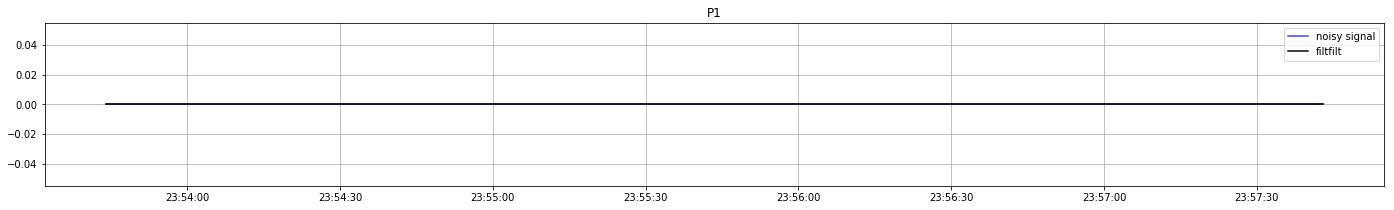

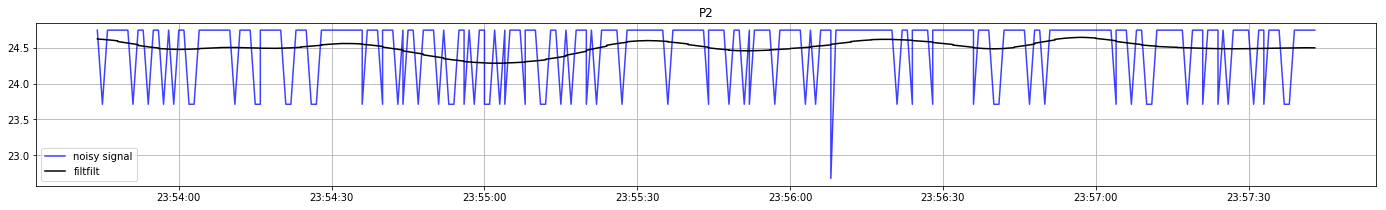

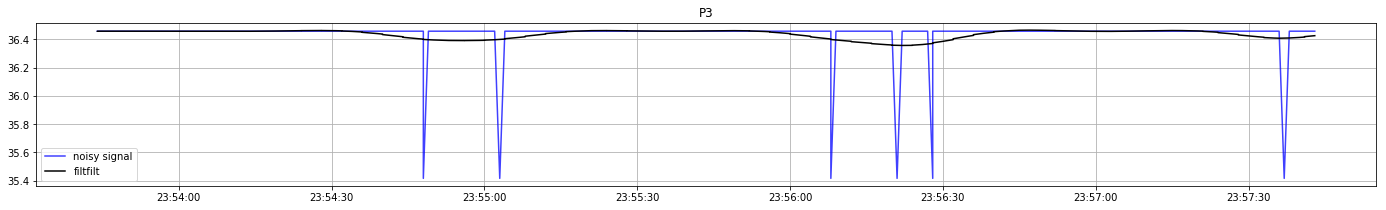

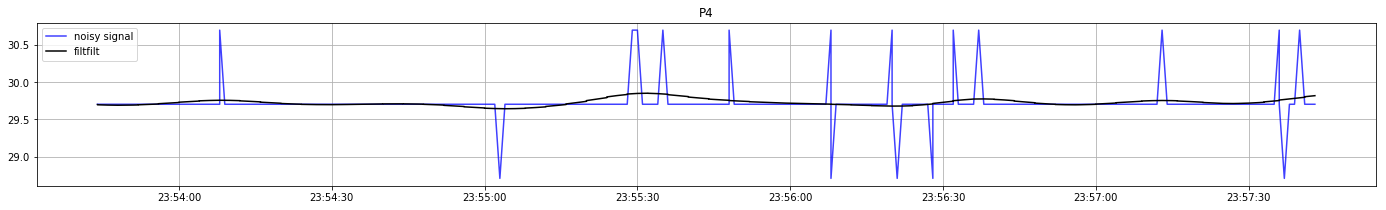

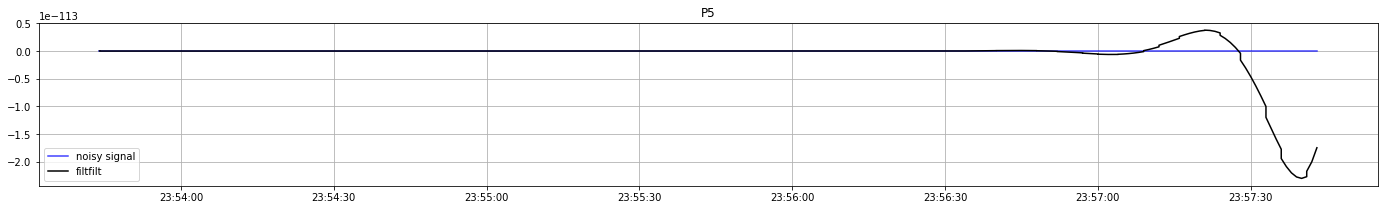

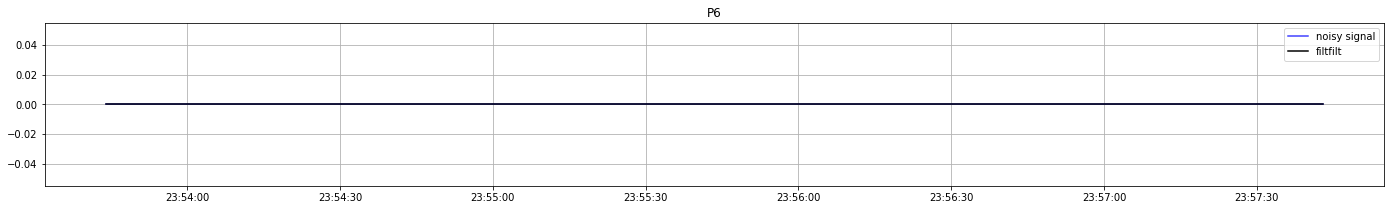

In [21]:
t = datos['DateTime'][11500:11800]
for i in datos.iloc[:,1:len(datos.columns)-1]:
    plt.figure(figsize=(24,3))
    plt.plot(t, dt[i][11500:11800], 'b', alpha=0.75)
    plt.plot(t, dtN[i][11500:11800], 'k')
    plt.legend(('noisy signal','filtfilt'), loc='best')
    plt.title(i)
    plt.grid(True)
    plt.savefig(i+".svg")

### Cálculo de las  estadísticas móviles
#### Widgets

In [12]:
import gc
gc.collect()

15333

In [13]:
import ipywidgets as widgets
from IPython.display import display

slider = widgets.IntSlider(
    value=25,
    min=1,
    max=50,
    description='Ventana:',
    readout=True,
    readout_format='d'
)

button = widgets.Button(
    description='Calcular'
)

progress = widgets.IntProgress(
    value=0,
    min=0,
    max=12,
    step=1,
    description='Procesado:',
    bar_style='', # 'success', 'info', 'warning', 'danger' or ''
    orientation='horizontal'
)

hb = widgets.HBox([slider,button,progress])

In [14]:
display(hb)

dataE = datos.copy()

def estadisticos(b):
    global slider, dataE, progress
    
    progress.value = 0
    
    before = b.description
    b.description='Espera'

    print(" "*100,end='\r')
    
    ventanaMedia = slider.value
    
    for i in range(1,len(datos.columns)-1):
        nombre_col = 'P'+str(i)
        nombre_col_mean = nombre_col+' mean'
        dataE[nombre_col_mean] = dataE[nombre_col].rolling(ventanaMedia).mean()
        progress.value += 1

    ventanaDesviacion = ventanaMedia

    for i in range(1,len(datos.columns)-1):
        nombre_col = 'P'+str(i)
        nombre_col_std = nombre_col+' std'
        dataE[nombre_col_std] = dataE[nombre_col].rolling(ventanaDesviacion).std()
        progress.value += 1
        
    print('Calculos realizados para ventana a',ventanaMedia,end="\r")
    b.description = before
        
    dataE = dataE.dropna()
    

button.on_click(estadisticos)


In [15]:
dataE.head()

,DateTime,P1,P2,P3,P4,P5,P6,target,P1 mean,P2 mean,P3 mean,P4 mean,P5 mean,P6 mean,P1 std,P2 std,P3 std,P4 std,P5 std,P6 std
4041065,2018-10-30 21:20:41,0.0,24.330140,28.975939,22.873583,0.0,0.0,False,0.0,26.400677,29.826624,23.299152,0.0,0.0,0.0,1.196516,0.449256,0.228480,0.0,0.0
4041066,2018-10-30 21:20:41,0.0,24.179377,28.900269,22.798271,0.0,0.0,False,0.0,26.250357,29.770323,23.295851,0.0,0.0,0.0,1.230980,0.473960,0.235270,0.0,0.0
4041067,2018-10-30 21:20:42,0.0,24.038676,28.828217,22.725685,0.0,0.0,False,0.0,26.095660,29.710582,23.284963,0.0,0.0,0.0,1.256968,0.495210,0.255098,0.0,0.0
4041068,2018-10-30 21:20:43,0.0,23.908417,28.760066,22.656591,0.0,0.0,False,0.0,25.937780,29.648037,23.267094,0.0,0.0,0.0,1.274483,0.512972,0.282524,0.0,0.0
4041069,2018-10-30 21:20:44,0.0,23.788802,28.695967,22.591578,0.0,0.0,False,0.0,25.777864,29.583271,23.242863,0.0,0.0,0.0,1.283609,0.527255,0.313079,0.0,0.0


### Exportación

In [16]:
import pickle as pk

In [17]:
with open('datos.pdd','wb') as f:
    pk.dump(datos,f)
    
with open('datosE.pdd','wb') as f:
    pk.dump(dataE,f)